In [140]:
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from time import time
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt

from utils import translate_iso_639_1_to_639_3, translate_iso_639_3_to_full_name

tqdm.pandas()

In [2]:
DATA_DIR = Path("data")
RESULTS_DIR = Path("results")

RESULTS_DIR.mkdir(exist_ok=True)

## Load the data

In [3]:
df_test = pd.read_feather(DATA_DIR / "wili_2018_test.feather")
df_test

,sentence,label,label_ISO369-3,lang_name
0,Ne l fin de l seclo XIX l Japon era inda çconh...,8,mwl,Mirandese
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,185,nld,Dutch
2,"ГIурусаз батальонал, гьоркьор гIарадабиги лъун...",28,ava,Avaric
3,ರಾಜ್ಯಶಾಸ್ತ್ರದ ಪಿತಾಮಹೆ ಅರಿಸ್ಟಾಟಲ್. ರಾಜ್ಯಶಾಸ್ತ್ರ...,231,tcy,Tulu
4,Halukum adalah kelenjar tiroid nang menonjol d...,121,bjn,Banjar
...,...,...,...,...
117495,"Wakati wa mimba,homa ya Q ni vigumu kutibu kwa...",32,swa,Swahili (macrolanguage)
117496,گیلون یک ته تاریخی منطقه‌ سفیدرود دلتای طرف ای...,1,glk,Gilaki
117497,តាម​រយៈ​ការ​ចិញ្ចឹម​មនោសញ្ចេតនា​ជាតិនិយម​បែប​ន...,73,khm,Khmer
117498,روس اک وفاق اے تے 1 مارچ 2008ء توں اسدیاں 83 و...,103,pnb,Western Panjabi


## Common languages among the tools

In [4]:
import langdetect

In [5]:
langdetect_langs = list(map(str.strip, """
af, ar, bg, bn, ca, cs, cy, da, de, el, en, es, et, fa, fi, fr, gu, he,
hi, hr, hu, id, it, ja, kn, ko, lt, lv, mk, ml, mr, ne, nl, no, pa, pl,
pt, ro, ru, sk, sl, so, sq, sv, sw, ta, te, th, tl, tr, uk, ur, vi, zh-cn, zh-tw
""".split(",")))

langdetect_langs_iso_369_3 = [translate_iso_639_1_to_639_3(lang) for lang in langdetect_langs]
langdetect_langs_iso_369_3 = [lang for lang in langdetect_langs_iso_369_3 if lang is not None]
len(langdetect_langs_iso_369_3)

53

In [6]:
from lingua import Language

In [7]:
lingua_langs_iso_369_3 = [
    lang.iso_code_639_3.name.lower()
    for lang in Language.all()
]
len(lingua_langs_iso_369_3)

75

In [8]:
common_langs_iso_369_3 = set(langdetect_langs_iso_369_3) & set(lingua_langs_iso_369_3)
len(common_langs_iso_369_3), common_langs_iso_369_3

(49,
 {'afr',
  'ara',
  'ben',
  'bul',
  'cat',
  'ces',
  'cym',
  'dan',
  'deu',
  'ell',
  'eng',
  'est',
  'fas',
  'fin',
  'fra',
  'guj',
  'heb',
  'hin',
  'hrv',
  'hun',
  'ind',
  'ita',
  'jpn',
  'kor',
  'lav',
  'lit',
  'mar',
  'mkd',
  'nld',
  'pan',
  'pol',
  'por',
  'ron',
  'rus',
  'slk',
  'slv',
  'som',
  'spa',
  'sqi',
  'swa',
  'swe',
  'tam',
  'tel',
  'tgl',
  'tha',
  'tur',
  'ukr',
  'urd',
  'vie'})

In [9]:
df_test_only_common_langs = df_test[df_test["label_ISO369-3"].isin(common_langs_iso_369_3)]
df_test_only_common_langs

,sentence,label,label_ISO369-3,lang_name
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,185,nld,Dutch
8,Оперативните програми (ОП) като форма на финан...,66,bul,Bulgarian
15,كانت رحلة كوك - فولسوم - بيترسون الاستكشافية ع...,10,ara,Arabic
22,"대구는 높고 규모가 큰 산줄기로 둘러싸인 분지 지형이다. 북쪽에는 팔공산(1,193...",95,kor,Korean
25,Argentina adalah sebuah negara yang kaya denga...,101,ind,Indonesian
...,...,...,...,...
117481,वासुकीमध्ये तीन मेसिए वस्तू आहेत. वासुकी आणि न...,195,mar,Marathi
117484,"Блайтські фігури, (Інтагліо (Мохаве)) англ. Bl...",104,ukr,Ukrainian
117490,Do sezone 2008./09. je ligu činilo 14 nogometn...,67,hrv,Croatian
117494,Estiske militære tropper skal formindskes til ...,62,dan,Danish


## langdetect

In [10]:
def pred_langdetect(text) -> str | None:
    chars, tokens = len(text), len(text.split())
    t0 = time()
    try:
        pred = langdetect.detect_langs(text)[0]  # pred is already sorted by probability
    except Exception as e:
        print(f"Error: {e} | Text: {text}")
        return ":".join(["None"]*5)
    pred_time_s = time() - t0
    lang_iso_369_1, prob = pred.lang, pred.prob
    return ":".join([
        str(translate_iso_639_1_to_639_3(lang_iso_369_1)),
        str(prob),
        str(chars),
        str(tokens),
        str(pred_time_s)
    ])


df_langdetect_pred = df_test_only_common_langs.copy()
df_langdetect_pred["pred"] = df_langdetect_pred["sentence"].progress_apply(pred_langdetect)

  0%|          | 0/24500 [00:00<?, ?it/s]

Error: No features in text. | Text: 1907, 1908, 1909, 1911,1914, 1919, 1939, 1950, 1951, 1952, 1953, 1955, 1956, 1957, 1959, 1960, 1961, 1962, 1964, 1965, 1966, 1967, 1973, 1977, 1983, 1986, 1999, 2003
Error: No features in text. | Text: 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1924, 1925, 1926, 1930, 1933, 1936, 1940, 1949, 1950, 1952, 1953,1954, 1960, 1964, 1968, 1973, 1974, 1975, 1977, 1978, 1979, 1986, 1989, 1990, 1991, 1993, 1994, 1995, 1996, 1997, 1999, 2003, 2004, 2007, 2008, 2014


In [11]:
df_langdetect_pred = df_langdetect_pred[~df_langdetect_pred["pred"].str.startswith("None:")]
df_langdetect_pred

,sentence,label,label_ISO369-3,lang_name,pred
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,185,nld,Dutch,nld:0.9999941302255804:295:48:0.18126583099365234
8,Оперативните програми (ОП) като форма на финан...,66,bul,Bulgarian,bul:0.99999751889935:652:88:0.0024480819702148438
15,كانت رحلة كوك - فولسوم - بيترسون الاستكشافية ع...,10,ara,Arabic,ara:0.9999982154017655:859:137:0.0017054080963...
22,"대구는 높고 규모가 큰 산줄기로 둘러싸인 분지 지형이다. 북쪽에는 팔공산(1,193...",95,kor,Korean,kor:0.9999992496551929:168:35:0.00050926208496...
25,Argentina adalah sebuah negara yang kaya denga...,101,ind,Indonesian,ind:0.9999964696913404:638:81:0.00173020362854...
...,...,...,...,...,...
117481,वासुकीमध्ये तीन मेसिए वस्तू आहेत. वासुकी आणि न...,195,mar,Marathi,mar:0.9999968144520742:177:27:0.00125861167907...
117484,"Блайтські фігури, (Інтагліо (Мохаве)) англ. Bl...",104,ukr,Ukrainian,ukr:0.9999984294065103:290:38:0.00087594985961...
117490,Do sezone 2008./09. je ligu činilo 14 nogometn...,67,hrv,Croatian,hrv:0.9999972483581254:221:33:0.00195264816284...
117494,Estiske militære tropper skal formindskes til ...,62,dan,Danish,dan:0.9999934633704843:201:29:0.00265812873840...


In [12]:
def explode_pred(df: pd.DataFrame, explode_columns: List[str], pred_colname: str) -> pd.DataFrame:
    if all([exp_col in df.columns for exp_col in explode_columns]):
        print("Columns already exploded")
        return df
    df_temp = df[pred_colname].str.split(":", expand=True)
    df_temp.columns = explode_columns
    return pd.concat([df, df_temp], axis=1)

In [36]:
df_langdetect_pred = explode_pred(
    df=df_langdetect_pred,
    explode_columns=["pred_ISO369-3", "pred_prob", "chars", "tokens", "pred_time_s"],
    pred_colname="pred"
)
df_langdetect_pred["pred_prob"] = df_langdetect_pred["pred_prob"].astype(float)
df_langdetect_pred["chars"] = df_langdetect_pred["chars"].astype(int)
df_langdetect_pred["tokens"] = df_langdetect_pred["tokens"].astype(int)
df_langdetect_pred["pred_time_s"] = df_langdetect_pred["pred_time_s"].astype(float)


df_langdetect_pred.to_csv(RESULTS_DIR / "langdetect_pred.csv", index=False)
df_langdetect_pred

,sentence,label,label_ISO369-3,lang_name,pred,pred_ISO369-3,pred_prob,chars,tokens,pred_time_s
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,185,nld,Dutch,nld:0.9999941302255804:295:48:0.18126583099365234,nld,0.999994,295,48,0.181266
8,Оперативните програми (ОП) като форма на финан...,66,bul,Bulgarian,bul:0.99999751889935:652:88:0.0024480819702148438,bul,0.999998,652,88,0.002448
15,كانت رحلة كوك - فولسوم - بيترسون الاستكشافية ع...,10,ara,Arabic,ara:0.9999982154017655:859:137:0.0017054080963...,ara,0.999998,859,137,0.001705
22,"대구는 높고 규모가 큰 산줄기로 둘러싸인 분지 지형이다. 북쪽에는 팔공산(1,193...",95,kor,Korean,kor:0.9999992496551929:168:35:0.00050926208496...,kor,0.999999,168,35,0.000509
25,Argentina adalah sebuah negara yang kaya denga...,101,ind,Indonesian,ind:0.9999964696913404:638:81:0.00173020362854...,ind,0.999996,638,81,0.001730
...,...,...,...,...,...,...,...,...,...,...
117481,वासुकीमध्ये तीन मेसिए वस्तू आहेत. वासुकी आणि न...,195,mar,Marathi,mar:0.9999968144520742:177:27:0.00125861167907...,mar,0.999997,177,27,0.001259
117484,"Блайтські фігури, (Інтагліо (Мохаве)) англ. Bl...",104,ukr,Ukrainian,ukr:0.9999984294065103:290:38:0.00087594985961...,ukr,0.999998,290,38,0.000876
117490,Do sezone 2008./09. je ligu činilo 14 nogometn...,67,hrv,Croatian,hrv:0.9999972483581254:221:33:0.00195264816284...,hrv,0.999997,221,33,0.001953
117494,Estiske militære tropper skal formindskes til ...,62,dan,Danish,dan:0.9999934633704843:201:29:0.00265812873840...,dan,0.999993,201,29,0.002658


## Lingua

In [14]:
from lingua import LanguageDetectorBuilder, IsoCode639_3

common_langs_iso_369_3_objs = [getattr(IsoCode639_3, lang.upper()) for lang in common_langs_iso_369_3]
lingua_detector = (
    LanguageDetectorBuilder.from_iso_codes_639_3(*common_langs_iso_369_3_objs)
    .with_preloaded_language_models()
    # .with_low_accuracy_mode()  # for mostly long texts or need to save resources, enables a low accuracy mode that loads only a small subset of the language models into memory
    .build()
)

In [15]:
def pred_lingua(text, detector) -> str | None:
    chars, tokens = len(text), len(text.split())
    t0 = time()
    det_result = detector.compute_language_confidence_values(text)
    pred_time_s = time() - t0
    pred = sorted(det_result, key=lambda x: x.value, reverse=True)[0]
    lang_iso_369_3, prob = pred.language.iso_code_639_3.name.lower(), pred.value
    return ":".join([
        lang_iso_369_3,
        str(prob),
        str(chars),
        str(tokens),
        str(pred_time_s)
    ])


df_lingua_pred = df_test_only_common_langs.copy()
df_lingua_pred["pred"] = df_lingua_pred["sentence"].progress_apply(pred_lingua, args=(lingua_detector,))

  0%|          | 0/24500 [00:00<?, ?it/s]

In [39]:
df_lingua_pred = explode_pred(
    df=df_lingua_pred,
    explode_columns=["pred_ISO369-3", "pred_prob", "chars", "tokens", "pred_time_s"],
    pred_colname="pred"
)
df_lingua_pred["pred_prob"] = df_lingua_pred["pred_prob"].astype(float)
df_lingua_pred["chars"] = df_lingua_pred["chars"].astype(int)
df_lingua_pred["tokens"] = df_lingua_pred["tokens"].astype(int)
df_lingua_pred["pred_time_s"] = df_lingua_pred["pred_time_s"].astype(float)

df_lingua_pred.to_csv(RESULTS_DIR / "lingua_pred.csv", index=False)
df_lingua_pred.head()

Columns already exploded


,sentence,label,label_ISO369-3,lang_name,pred,pred_ISO369-3,pred_prob,chars,tokens,pred_time_s
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,185,nld,Dutch,nld:1.0:295:48:0.006137847900390625,nld,1.0,295,48,0.006138
8,Оперативните програми (ОП) като форма на финан...,66,bul,Bulgarian,bul:1.0:652:88:0.0012862682342529297,bul,1.0,652,88,0.001286
15,كانت رحلة كوك - فولسوم - بيترسون الاستكشافية ع...,10,ara,Arabic,ara:1.0:859:137:0.0011317729949951172,ara,1.0,859,137,0.001132
22,"대구는 높고 규모가 큰 산줄기로 둘러싸인 분지 지형이다. 북쪽에는 팔공산(1,193...",95,kor,Korean,kor:1.0:168:35:0.0005919933319091797,kor,1.0,168,35,0.000592
25,Argentina adalah sebuah negara yang kaya denga...,101,ind,Indonesian,ind:1.0:638:81:0.0013568401336669922,ind,1.0,638,81,0.001357


## Results

In [50]:
results_df = pd.concat([df_langdetect_pred, df_lingua_pred], axis="index")
results_df["tool"] = ["langdetect"] * len(df_langdetect_pred) + ["lingua"] * len(df_lingua_pred)
results_df

,sentence,label,label_ISO369-3,lang_name,pred,pred_ISO369-3,pred_prob,chars,tokens,pred_time_s,tool
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,185,nld,Dutch,nld:0.9999941302255804:295:48:0.18126583099365234,nld,0.999994,295,48,0.181266,langdetect
8,Оперативните програми (ОП) като форма на финан...,66,bul,Bulgarian,bul:0.99999751889935:652:88:0.0024480819702148438,bul,0.999998,652,88,0.002448,langdetect
15,كانت رحلة كوك - فولسوم - بيترسون الاستكشافية ع...,10,ara,Arabic,ara:0.9999982154017655:859:137:0.0017054080963...,ara,0.999998,859,137,0.001705,langdetect
22,"대구는 높고 규모가 큰 산줄기로 둘러싸인 분지 지형이다. 북쪽에는 팔공산(1,193...",95,kor,Korean,kor:0.9999992496551929:168:35:0.00050926208496...,kor,0.999999,168,35,0.000509,langdetect
25,Argentina adalah sebuah negara yang kaya denga...,101,ind,Indonesian,ind:0.9999964696913404:638:81:0.00173020362854...,ind,0.999996,638,81,0.001730,langdetect
...,...,...,...,...,...,...,...,...,...,...,...
117481,वासुकीमध्ये तीन मेसिए वस्तू आहेत. वासुकी आणि न...,195,mar,Marathi,mar:0.7263863123345409:177:27:0.00018954277038...,mar,0.726386,177,27,0.000190,lingua
117484,"Блайтські фігури, (Інтагліо (Мохаве)) англ. Bl...",104,ukr,Ukrainian,ukr:1.0:290:38:0.00027561187744140625,ukr,1.000000,290,38,0.000276,lingua
117490,Do sezone 2008./09. je ligu činilo 14 nogometn...,67,hrv,Croatian,hrv:1.0:221:33:0.0003046989440917969,hrv,1.000000,221,33,0.000305,lingua
117494,Estiske militære tropper skal formindskes til ...,62,dan,Danish,dan:0.9999999999999791:201:29:0.00036954879760...,dan,1.000000,201,29,0.000370,lingua


In [97]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [100]:
langdetect_report = classification_report(y_true=df_langdetect_pred["label_ISO369-3"], y_pred=df_langdetect_pred["pred_ISO369-3"], zero_division=0, output_dict=True)
print(langdetect_report)

{'afr': {'precision': 0.9959919839679359, 'recall': 0.994, 'f1-score': 0.994994994994995, 'support': 500.0}, 'ara': {'precision': 0.9054545454545454, 'recall': 0.996, 'f1-score': 0.9485714285714286, 'support': 500.0}, 'ben': {'precision': 1.0, 'recall': 0.882, 'f1-score': 0.9373007438894793, 'support': 500.0}, 'bul': {'precision': 0.9979296066252588, 'recall': 0.964, 'f1-score': 0.9806714140386572, 'support': 500.0}, 'cat': {'precision': 0.9957716701902748, 'recall': 0.942, 'f1-score': 0.9681397738951696, 'support': 500.0}, 'ces': {'precision': 0.9898373983739838, 'recall': 0.974, 'f1-score': 0.9818548387096774, 'support': 500.0}, 'cym': {'precision': 1.0, 'recall': 0.994, 'f1-score': 0.9969909729187563, 'support': 500.0}, 'dan': {'precision': 1.0, 'recall': 0.96, 'f1-score': 0.9795918367346939, 'support': 500.0}, 'deu': {'precision': 0.8840579710144928, 'recall': 0.976, 'f1-score': 0.9277566539923955, 'support': 500.0}, 'ell': {'precision': 1.0, 'recall': 0.988, 'f1-score': 0.99396378

In [99]:
lingua_report = classification_report(y_true=df_lingua_pred["label_ISO369-3"], y_pred=df_lingua_pred["pred_ISO369-3"], zero_division=0, output_dict=True)
print(lingua_report)

{'afr': {'precision': 0.9877049180327869, 'recall': 0.964, 'f1-score': 0.9757085020242915, 'support': 500.0}, 'ara': {'precision': 0.9289719626168225, 'recall': 0.994, 'f1-score': 0.9603864734299516, 'support': 500.0}, 'ben': {'precision': 1.0, 'recall': 0.884, 'f1-score': 0.9384288747346072, 'support': 500.0}, 'bul': {'precision': 1.0, 'recall': 0.954, 'f1-score': 0.9764585465711362, 'support': 500.0}, 'cat': {'precision': 0.9978632478632479, 'recall': 0.934, 'f1-score': 0.9648760330578512, 'support': 500.0}, 'ces': {'precision': 0.9858299595141701, 'recall': 0.974, 'f1-score': 0.9798792756539235, 'support': 500.0}, 'cym': {'precision': 0.9801980198019802, 'recall': 0.99, 'f1-score': 0.9850746268656716, 'support': 500.0}, 'dan': {'precision': 0.9918367346938776, 'recall': 0.972, 'f1-score': 0.9818181818181818, 'support': 500.0}, 'deu': {'precision': 0.8842676311030742, 'recall': 0.978, 'f1-score': 0.9287749287749287, 'support': 500.0}, 'ell': {'precision': 1.0, 'recall': 0.982, 'f1-sc

In [102]:
def add_bar_labels(ax):
    """
    Add labels on top of each bar in seaborn barplot.
    """
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + (p.get_height() * 0.8)
        value = '{:.3f}'.format(p.get_height())
        if value == '{:.3f}'.format(0):
            continue
        ax.text(_x, _y, value, ha="center", va='bottom', fontsize=8)

In [101]:
tools_acc_df = pd.DataFrame({
    "Tool": ["langdetect", "lingua"],
    "F1": [langdetect_report["weighted avg"]["f1-score"], lingua_report["weighted avg"]["f1-score"]],
    "Recall": [langdetect_report["weighted avg"]["recall"], lingua_report["weighted avg"]["recall"]],
    "Precision": [langdetect_report["weighted avg"]["precision"], lingua_report["weighted avg"]["precision"]],
})
tools_acc_df

,Tool,F1,Recall,Precision
0,langdetect,0.975986,0.973749,0.981486
1,lingua,0.971756,0.970163,0.976265


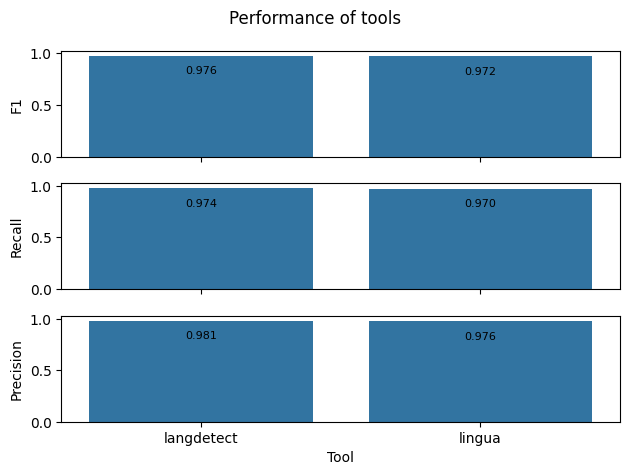

In [129]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)

ycols = ["F1", "Recall", "Precision"]
for i, ycol in enumerate(ycols):
    sns.barplot(
        ax=axes[i],
        data=tools_acc_df,
        x='Tool',
        y=ycol,
    )
    add_bar_labels(axes[i])

plt.suptitle("Performance of tools")
plt.tight_layout()
plt.show()

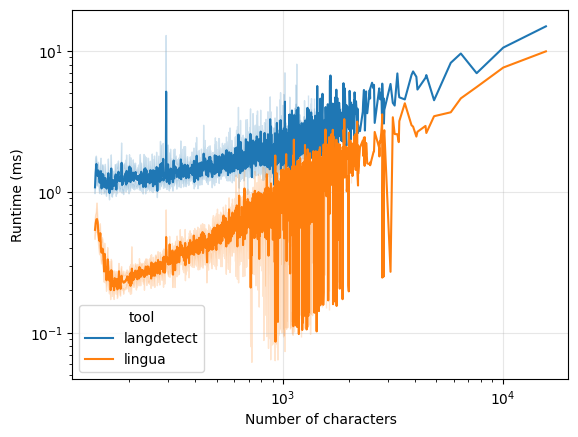

In [75]:
results_df_plot = results_df.copy()
results_df_plot["pred_time_ms"] = results_df_plot["pred_time_s"] * 1000

sns.lineplot(
    data=results_df_plot,
    x="chars",
    y="pred_time_ms",
    hue="tool",
)
plt.xlabel("Number of characters")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Runtime (ms)")
plt.grid(alpha=0.3)
plt.show()

In [77]:
results_df_plot["pred_time_ms_per_char"] = results_df_plot["pred_time_ms"] / results_df_plot["chars"]

results_df_plot["pred_time_ms_per_char"].describe()

count    48994.000000
mean         0.002975
std          0.004509
min          0.000015
25%          0.001173
50%          0.001963
75%          0.003650
max          0.614460
Name: pred_time_ms_per_char, dtype: float64

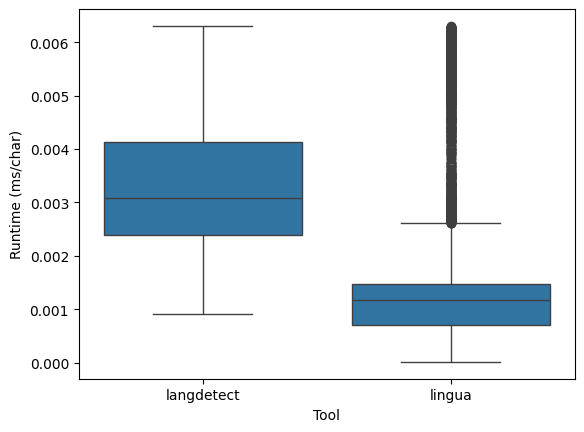

In [94]:
sns.boxplot(
    data=results_df_plot[results_df_plot["pred_time_ms_per_char"] <= results_df_plot["pred_time_ms_per_char"].quantile(0.9)],
    x="tool",
    y="pred_time_ms_per_char",
)
plt.xlabel("Tool")
plt.ylabel("Runtime (ms/char)")
plt.show()

In [126]:
most_popular_langs_iso_369_3 = [
    "eng",  # English
    "spa",  # Spanish
    "fra",  # French
    "deu",  # German
    "rus",  # Russian
    "jpn",  # Japanese
    "hin",  # Hindi
    "ara",  # Arabic
    "por"   # Portuguese
]
len(most_popular_langs_iso_369_3)  # 10 excluding Chinese

9

In [123]:
most_popular_langs_results_df = results_df[results_df["label_ISO369-3"].isin(most_popular_langs_iso_369_3)]
most_popular_langs_results_df

,sentence,label,label_ISO369-3,lang_name,pred,pred_ISO369-3,pred_prob,chars,tokens,pred_time_s,tool
15,كانت رحلة كوك - فولسوم - بيترسون الاستكشافية ع...,10,ara,Arabic,ara:0.9999982154017655:859:137:0.0017054080963...,ara,0.999998,859,137,0.001705,langdetect
26,立命館土曜講座は、大学の社会的開放および生涯教育への対応として実施している無料公開講座。当時...,140,jpn,Japanese,jpn:0.9999997782978569:235:1:0.000761270523071...,jpn,1.000000,235,1,0.000761,langdetect
43,16 апреля 2009 года в Шатойском районе произош...,24,rus,Russian,rus:0.9999968278846763:401:54:0.00204443931579...,rus,0.999997,401,54,0.002044,langdetect
50,La ciudad de San Cristóbal es sede del Hospita...,188,spa,Spanish,spa:0.999997474801927:193:32:0.002525806427001953,spa,0.999997,193,32,0.002526,langdetect
54,Les supporters de l'ASM Clermont Auvergne ont ...,82,fra,French,fra:0.9999965200258271:163:28:0.00099062919616...,fra,0.999997,163,28,0.000991,langdetect
...,...,...,...,...,...,...,...,...,...,...,...
117282,El investigador ha recibido varios reconocimie...,188,spa,Spanish,spa:1.0:813:127:0.0009655952453613281,spa,1.000000,813,127,0.000966,lingua
117300,Le village est une station familiale de sports...,82,fra,French,fra:1.0:317:56:0.00034046173095703125,fra,1.000000,317,56,0.000340,lingua
117308,Mozilla Add-ons は、Mozilla Firefox、Mozilla Thun...,140,jpn,Japanese,jpn:1.0:278:18:7.43865966796875e-05,jpn,1.000000,278,18,0.000074,lingua
117450,"Hors du terrain, les années 1920 et 30 sont de...",82,fra,French,fra:1.0:1257:204:0.0019180774688720703,fra,1.000000,1257,204,0.001918,lingua


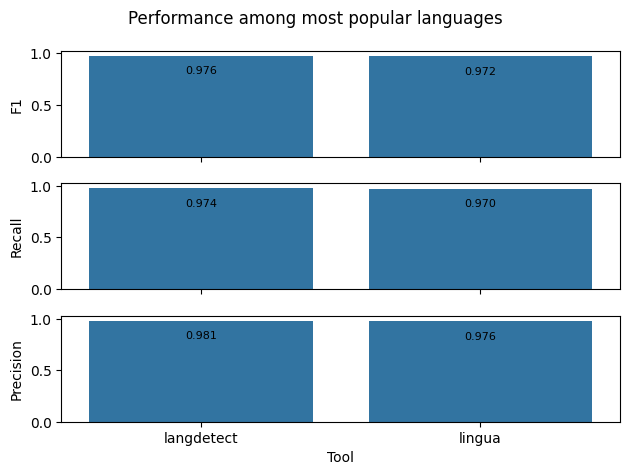

In [128]:
mp_langdetect_report = classification_report(
    y_true=most_popular_langs_results_df[most_popular_langs_results_df["tool"] == "langdetect"]["label_ISO369-3"],
    y_pred=most_popular_langs_results_df[most_popular_langs_results_df["tool"] == "langdetect"]["pred_ISO369-3"], 
    zero_division=0,
    output_dict=True
)
mp_lingua_report = classification_report(
    y_true=most_popular_langs_results_df[most_popular_langs_results_df["tool"] == "lingua"]["label_ISO369-3"],
    y_pred=most_popular_langs_results_df[most_popular_langs_results_df["tool"] == "lingua"]["pred_ISO369-3"], 
    zero_division=0,
    output_dict=True
)

mp_tools_acc_df = pd.DataFrame({
    "Tool": ["langdetect", "lingua"],
    "F1": [mp_langdetect_report["weighted avg"]["f1-score"], mp_lingua_report["weighted avg"]["f1-score"]],
    "Recall": [mp_langdetect_report["weighted avg"]["recall"], mp_lingua_report["weighted avg"]["recall"]],
    "Precision": [mp_langdetect_report["weighted avg"]["precision"], mp_lingua_report["weighted avg"]["precision"]],
})

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)

ycols = ["F1", "Recall", "Precision"]
for i, ycol in enumerate(ycols):
    sns.barplot(
        ax=axes[i],
        data=tools_acc_df,
        x='Tool',
        y=ycol,
    )
    add_bar_labels(axes[i])

plt.suptitle("Performance among most popular languages")
plt.tight_layout()
plt.show()

In [136]:
most_popular_langs_iso_369_3

['eng', 'spa', 'fra', 'deu', 'rus', 'jpn', 'hin', 'ara', 'por']

In [141]:
most_popular_langs = [translate_iso_639_3_to_full_name(lang) for lang in most_popular_langs_iso_369_3]
most_popular_langs

['English',
 'Spanish',
 'French',
 'German',
 'Russian',
 'Japanese',
 'Hindi',
 'Arabic',
 'Portuguese']

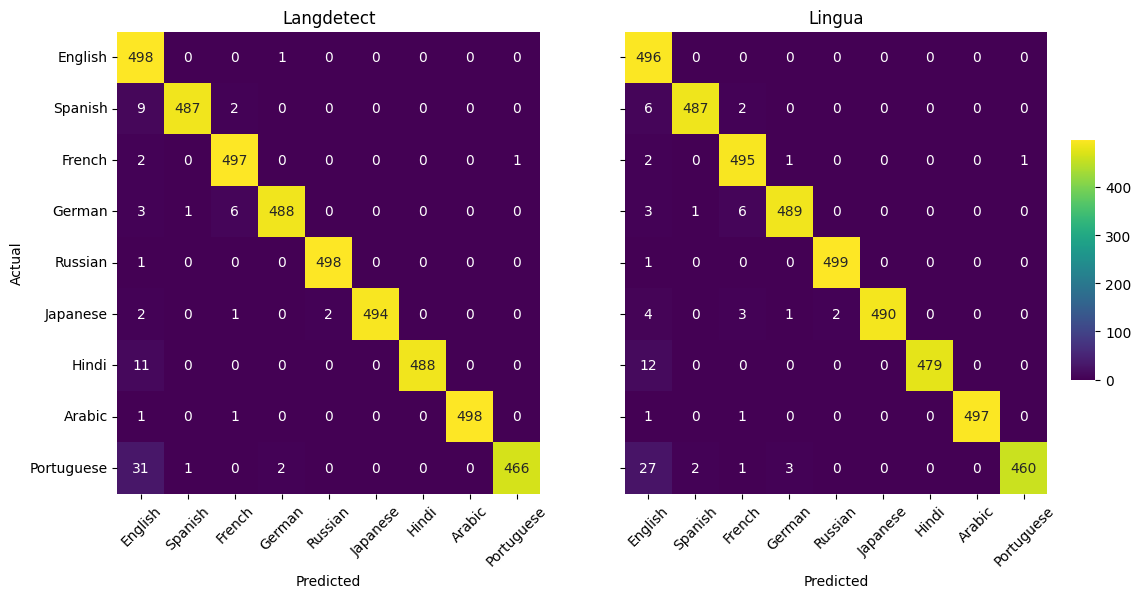

In [160]:
mp_langdetect_conf_matrix = confusion_matrix(
    y_true=most_popular_langs_results_df[most_popular_langs_results_df["tool"] == "langdetect"]["label_ISO369-3"],
    y_pred=most_popular_langs_results_df[most_popular_langs_results_df["tool"] == "langdetect"]["pred_ISO369-3"],
    labels=most_popular_langs_iso_369_3,
)
mp_lingua_report = confusion_matrix(
    y_true=most_popular_langs_results_df[most_popular_langs_results_df["tool"] == "lingua"]["label_ISO369-3"],
    y_pred=most_popular_langs_results_df[most_popular_langs_results_df["tool"] == "lingua"]["pred_ISO369-3"],
    labels=most_popular_langs_iso_369_3,
)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

sns.heatmap(mp_langdetect_conf_matrix, annot=True, fmt="d", ax=ax1, cbar=False)
sns.heatmap(mp_lingua_report, annot=True, fmt="d", ax=ax2, cbar=False)

# shared colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
sns.heatmap(mp_langdetect_conf_matrix, annot=False, cmap="viridis", ax=ax1, cbar=True, cbar_ax=cbar_ax)
sns.heatmap(mp_lingua_report, annot=False, cmap="viridis", ax=ax2, cbar=True, cbar_ax=cbar_ax)

ax1.set_title("Langdetect")
ax2.set_title("Lingua")
ax1.set_xlabel("Predicted")
ax2.set_xlabel("Predicted")
ax1.set_ylabel("Actual")
ax1.set_xticklabels(most_popular_langs, rotation=45)
ax2.set_xticklabels(most_popular_langs, rotation=45)
ax1.set_yticklabels(most_popular_langs, rotation=0)

plt.show()